In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aeons.utils import *
from aeons.regress import *
from aeons.endpoint import *
from aeons.plotting import *
figsettings()

In [137]:
name, samples = get_samples('gauss_32')
true_endpoint = EndModel(samples).true_endpoint()

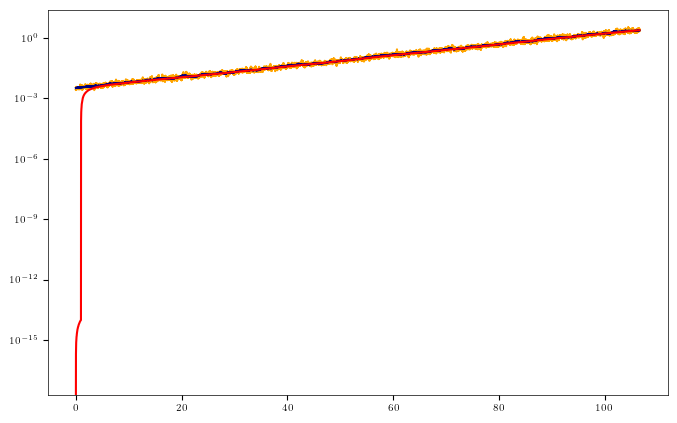

In [141]:
beta = -(dlogX_d/dlogL_d)
window = np.arange(0, true_endpoint)

plt.figure(figsize=(8, 5))
plt.plot(-samples.logX().iloc[window], -(dlogX/dlogL).iloc[window], color='orange')
plt.plot(-samples.logX().iloc[window], beta.iloc[window], color='navy')
plt.plot(-samples.logX().iloc[window], samples.beta_s.iloc[window], color='red')
plt.yscale('log')

$P(\beta | \log X^*) = \frac{P(\log X^* | \beta) P(\beta)}{P(\log X^*)}$

$ P(\log X) = P(X) \frac{dX}{d\log X} = P(X) X = \mathcal{L}X$

$ P(\log X^* |\beta) = \mathcal{L}^\beta X^*$

In [79]:
name, samples = get_samples('planck')
model = EndModel(samples)
true_endpoint = model.true_endpoint()

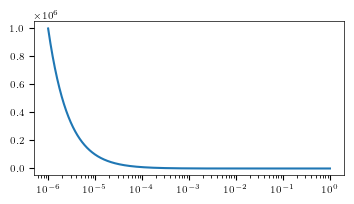

In [78]:
ndead = 10000
points = model.points(ndead)
logL = points.logL
logX = points.logX()

betas = np.logspace(-6, 0, 1000)
logLs, logXs = logL.iloc[ndead], logX.iloc[ndead]
xgivenbeta = np.exp(betas * logLs)
betagivenx = xgivenbeta * 1/betas
plt.plot(betas, betagivenx)
plt.xscale('log')

In [80]:
beta_s(samples)

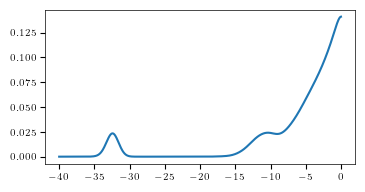

In [103]:
# KDE of beta_s
from scipy.stats import gaussian_kde
kde = gaussian_kde(np.log(samples.beta_s).drop(0))
betas = np.linspace(-40, 0, 1000)
plt.plot(betas, kde(betas))

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/plotting/_matplotlib/hist.py:57: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(self.bins[0], self.bins[-1])


Text(0.5, -1.8874339094065693, '$\\beta_s$')

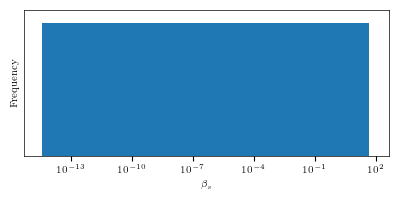

In [86]:
samples.plot_1d(['beta_s'], kind="hist_1d", logx=True)
plt.xlabel(r'$\beta_s$')

In [30]:
def beta_s(samples):
    from scipy.interpolate import interp1d
    beta = np.logspace(-14, 14, 1000)
    logL = samples.logL_P(beta=beta)/beta
    i = np.argmin(logL < samples.logL.max())
    beta = np.concatenate([[0],beta[:i+1]])
    logL = np.concatenate([[samples.logL.min()],logL.iloc[:i+1]])
    f = interp1d(logL, beta)
    samples['beta_s'] = f(samples.logL)

In [32]:
def get_beta_DKL(points, ndead):
    logX = points.logX().iloc[ndead]
    if logX < -points.D_KL():
        return 1
    def func(beta):
        return logX + points.set_beta(beta).D_KL()
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1])
    return res.root

def get_beta_end(points, ndead, epsilon=1e-2):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if (Zdead != 0):
        if (Zlive/Zdead < epsilon):
            return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        if (Zdead == 0):
            return np.inf
        return Zlive/Zdead - epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 1])
        return res.root
    except:
        return 0
    
def get_beta_start(points, ndead, epsilon=1e-2):
    logX = points.logX()
    logL = points.logL
    # Check if already terminated
    logw = logL + logX
    w = np.exp(logw - logw.max())
    Zdead = np.sum(w[:ndead])
    Zlive = np.sum(w[ndead:])
    if Zlive/Zdead < epsilon:
        return 1
    # Otherwise, find beta
    def func(beta):
        logw = beta * logL + logX
        w = np.exp(logw - logw.max())
        Zdead = np.sum(w[:ndead])
        Zlive = np.sum(w[ndead:])
        return Zlive/Zdead - 1/epsilon
    from scipy import optimize
    try:
        res = optimize.root_scalar(func, bracket=[0, 1e6])
        return res.root
    except:
        return 0
    
def get_beta_logL(points, ndead):
    logLs = points.logL.iloc[ndead]
    logL = points.logL.values
    logdX = points.logdX().values
    def func(beta):
        logw = beta * logL + logdX
        w = np.exp(logw - logw.max())
        logLP = np.sum(w * logL) / np.sum(w)
        return logLs - logLP
    from scipy import optimize
    res = optimize.root_scalar(func, bracket=[0, 1e5])
    return res.root

In [48]:
def logXf_dG_range_comb(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    beta_end = get_beta_end(points, ndead)
    beta_DKL = get_beta_DKL(points, ndead)
    if beta_end == 0:
        betas = np.linspace(0, beta_DKL, 10)
    else:
        betas = np.exp(np.linspace(np.log(beta_end), np.log(beta_DKL), 10))
    dG = points.d_G(nsamples=25, beta=betas)
    dG_mean, dG_std = dG.mean(), dG.std()
    ds = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        ds[i] = analytic_lm_params(logL[ndead:], X[ndead:], d0=1)[1]
    d_mean, d_std = ds.mean(), ds.std()
    dcomb = (dG_mean*d_std**2 + d_mean*dG_std**2)/(d_std**2 + dG_std**2)
    dcomb_std = np.sqrt((d_std**2 * dG_std**2)/(d_std**2 + dG_std**2))
    
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.normal(dcomb, dcomb_std)
        if d < 0:
            logXf_set[i] = np.nan
            continue
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set, 3)
    return logXf_set, f"{beta_DKL:.2e}, {beta_end:.2e}"

def logXf_dG_range(points, ndead, Nset=25, epsilon=0.02):
    logL, X_mean, nk, logZdead = data(points)
    beta_end = get_beta_end(points, ndead, epsilon=epsilon)
    beta_start = get_beta_start(points, ndead, epsilon=epsilon)
    if beta_end == 0:
        betas = np.linspace(0, beta_start, 10)
    elif (beta_end*beta_start == 1):
        betas = 1
    else:
        betas = np.exp(np.linspace(np.log(beta_end), np.log(beta_start), 10))
    dG = points.d_G(nsamples=25, beta=betas)
    dG_mean, dG_std = dG.mean(), dG.std()
    
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.normal(dG_mean, dG_std)
        while d < 0:
            d = np.random.normal(dG_mean, dG_std)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set, 3)
    return logXf_set, f"{beta_start:.2e}, {beta_end:.2e}"

def logXf_short(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    nlive = len(logL) - ndead
    start = ndead + int(0.75*nlive)
    logLd = logL[start:]
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        Xd = X[start:]
        theta = analytic_lm_params(logLd, Xd, d0=1)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
        if theta[1] > 360:
            theta = analytic_lm_params(logLd[:-100], Xd[:-100], d0=1)
            logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    logXf_set = reject_outliers(logXf_set)
    return logXf_set, f'{len(logXf_set)} samples'

def logXf_dG_logL(points, ndead, Nset=25):
    logL, X_mean, nk, logZdead = data(points)
    beta_logL = points.beta_s.iloc[ndead]
    dG = points.d_G(nsamples=25, beta=beta_logL)
    
    logXf_set = np.zeros(Nset)
    for i in range(Nset):
        X = generate_Xs(nk)
        d = np.random.choice(dG)
        theta = params_from_d(logL[ndead:], X[ndead:], d)
        logXf_set[i] = logXf_formula(theta, logZdead, X_mean[ndead])
    logXf_set = logXf_set[~np.isnan(logXf_set)]
    return logXf_set, f"{beta_logL:.2e}, {len(logXf_set)} samples"

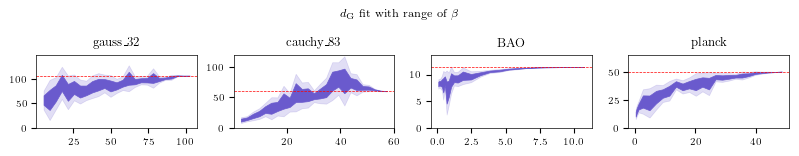

In [47]:
test_chains = ['gauss_32', 'cauchy_83', 'BAO', 'planck']
ylims = [(0, 1.4), (0, 2), (0, 1.2), (0, 1.3)]
fig, axs = plt.subplots(1, 4, figsize=(8, 1.5))
axs = axs.flatten()
for i, chain in enumerate(test_chains):
    name, samples = get_samples(chain)
    iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_range_{name}.txt")
    logXf_true = samples.logX().iloc[int(true_endpoint)]
    logXs = samples.logX().iloc[iterations]
    plot_std(-logXs, -logXfs, logXfs_std, -logXf_true, ax=axs[i], color='slateblue', ylim=ylims[i])
    axs[i].set_title(name)
fig.suptitle("$d_\\mathrm{G}$ fit with range of $\\beta$")
fig.tight_layout()

In [19]:
def beta_s(samples):
    from scipy.interpolate import interp1d
    beta = np.logspace(-14, 14, 1000)
    logL = samples.logL_P(beta=beta)/beta
    i = np.argmin(logL < samples.logL.max())
    beta = np.concatenate([[0],beta[:i+1]])
    logL = np.concatenate([[samples.logL.min()],logL.iloc[:i+1]])
    f = interp1d(logL, beta)
    samples['beta_s'] = f(samples.logL)

In [123]:
name, samples = get_samples('SH0ES')
# beta_s(samples)
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()

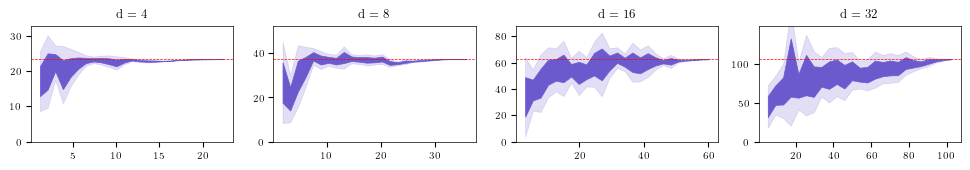

In [50]:
fig, axs = plt.subplots(1, 4, figsize=(12, 1.5))
axs = axs.flatten()
for i, chain in enumerate(gauss_chains):
    name, samples = get_samples(chain)
    iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_range/02_{name}.txt")
    logXs = samples.logX().iloc[iterations]
    true_logXf = samples.logX().iloc[int(true_endpoint)]
    plot_std(-logXs, -logXfs, logXfs_std, -true_logXf, ax=axs[i], color='slateblue', ylim=(0, 1.4))
    axs[i].set_title(f"d = {name[6:]}")

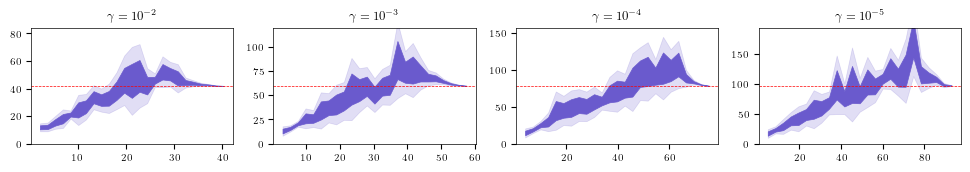

In [60]:
fig, axs = plt.subplots(1, 4, figsize=(12, 1.5))
axs = axs.flatten()
for i, chain in enumerate(cauchy_chains):
    name, samples = get_samples(chain)
    iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_range/02_{name}.txt")
    logXs = samples.logX().iloc[iterations]
    true_logXf = samples.logX().iloc[int(true_endpoint)]
    plot_std(-logXs, -logXfs, logXfs_std, -true_logXf, ax=axs[i], color='slateblue', ylim=(0, 2))
    axs[i].set_title(f"$\\gamma = 10^{{-{name[8:]}}}$")

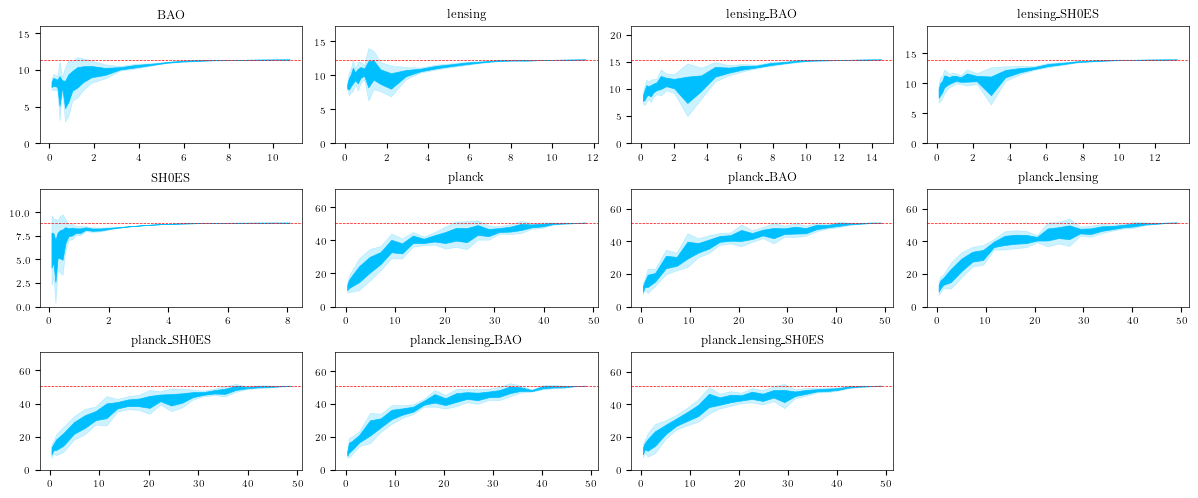

In [45]:
fig, axs = plt.subplots(3, 4, figsize=(12, 5))
axs = axs.flatten()
fig.delaxes(axs[-1])
for i, chain in enumerate(lcdm_chains):
    name, samples = get_samples(chain)
    iterations, logXfs, logXfs_std, true_endpoint = read_from_txt(f"data/dG_range/02_{name}.txt")
    logXs = samples.logX().iloc[iterations]
    true_logXf = samples.logX().iloc[int(true_endpoint)]
    plot_std(-logXs, -logXfs, logXfs_std, -true_logXf, ax=axs[i], color='deepskyblue', ylim=(0, 1.4))
    axs[i].set_title(name)
fig.tight_layout()

In [16]:
from joblib import Parallel, delayed
import os
def process_chain(chain):
    name, samples = get_samples(chain)
    model = EndModel(samples)
    true_endpoint = model.true_endpoint()
    iterations = make_iterations(true_endpoint, 25)
    logXfs, logXfs_std = model.logXfs(logXf_dG_range, iterations, Nset=25, epsilon=0.02)
    write_to_txt(f"data/dG_range/02_{chain}.txt", [iterations, logXfs, logXfs_std, true_endpoint])

# Parallelize the loop over test_chains
num_jobs = min(len(test_chains), os.cpu_count())  # Number of parallel jobs based on CPU count
Parallel(n_jobs=num_jobs)(delayed(process_chain)(chain) for chain in all_chains)

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 933 of 17955, 4.30e-03, 0.00e+00

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 3947 of 30138, 1.25e-02, 2.01e-03

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 6721 of 51318, 2.07e-02, 4.81e-03

/tmp/ipykernel_49099/354420414.py:20: RuntimeWarning: overflow encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:30: RuntimeWarning: overflow encountered in scalar divide


 Iteration 2357 of 11228, 1.78e-02, 5.58e-04

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: overflow encountered in scalar divide


 Iteration 18884 of 51318, 8.52e-02, 2.10e-02

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 19423 of 30138, 5.83e-01, 1.02e-01

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 14409 of 17955, 3.86e+00, 3.73e-01

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 17955 of 17955, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 9809 of 20164, 1.85e+00, 8.42e-011

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 11402 of 20164, 1.91e+00, 8.55e-01

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 4943 of 37745, 2.13e+00, 6.87e-011

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:137: RuntimeWarning: divide by zero encountered in scalar divide
  loglive = loggamma(d/2) + np.log(gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: divide by zero encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: invalid value encountered in scalar subtract
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)


 Iteration 20164 of 20164, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide
/home/zixiao/Documents/III/project/aeons/aeons/regress.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:137: RuntimeWarning: divide by zero encountered in scalar divide
  loglive = loggamma(d/2) + np.log(gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: divide by zero encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: invalid value encountered in scalar subtract
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)


 Iteration 51318 of 51318, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 6099 of 46565, 1.84e+00, 7.40e-011

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 2973 of 17440, 6.34e-02, 0.00e+001

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 28753 of 28753, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 10551 of 17440, 4.54e+00, 5.93e-02

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 37745 of 37745, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 8907 of 18310, 1.25e-01, 4.08e-041

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 6532 of 19886, 1.30e-02, 0.00e+001

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:137: RuntimeWarning: divide by zero encountered in scalar divide
  loglive = loggamma(d/2) + np.log(gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: divide by zero encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: invalid value encountered in scalar subtract
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)


 Iteration 14694 of 18310, 3.13e+01, 6.60e-01

/home/zixiao/Documents/III/project/aeons/aeons/regress.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:137: RuntimeWarning: divide by zero encountered in scalar divide
  loglive = loggamma(d/2) + np.log(gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: divide by zero encountered in log
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
/home/zixiao/Documents/III/project/aeons/aeons/utils.py:138: RuntimeWarning: invalid value encountered in scalar subtract
  logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)


 Iteration 16140 of 18310, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 18310 of 18310, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 11186 of 21267, 6.16e-01, 6.13e-03

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 3049 of 14522, 1.36e-01, 0.00e+000

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 8212 of 14522, 3.02e+00, 0.00e+000

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 19886 of 19886, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 11736 of 55892, 3.76e-03, 1.13e-04

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 9417 of 55241, 1.09e-03, 1.79e-053

/tmp/ipykernel_49099/354420414.py:30: RuntimeWarning: overflow encountered in scalar divide


 Iteration 15963 of 55241, 1.78e-02, 1.05e-03

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 33390 of 55191, 6.11e-01, 8.81e-02

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 42111 of 55191, 1.86e+00, 3.34e-01

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 44853 of 55892, 2.47e+00, 4.22e-01

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 56003 of 56003, 1.00e+00, 1.00e+00

/tmp/ipykernel_49099/354420414.py:46: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: divide by zero encountered in scalar divide


 Iteration 16132 of 55826, 1.79e-02, 1.09e-03

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 22748 of 55826, 8.80e-02, 8.89e-03

/tmp/ipykernel_49099/354420414.py:54: RuntimeWarning: overflow encountered in scalar divide


 Iteration 55826 of 55826, 1.00e+00, 1.00e+00

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
name, samples = get_samples('BAO')
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = model.true_logXf()
iterations = make_iterations(true_endpoint, 25)
logXfs, logXfs_std = model.logXfs(logXf_dG_range, iterations, Nset=25, epsilon=1e-2)
write_to_txt(f"data/dG_range_{name}.txt", [iterations, logXfs, logXfs_std, true_endpoint])

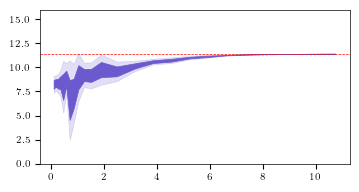

In [14]:
logXs = samples.logX().iloc[iterations]
plot_std(-logXs, -logXfs, logXfs_std, -true_logXf, color='slateblue', ylim=(0, 1.4))